# Apartment rental offers in Germany
*Laetitia, Quinten, Johan, Manuel*

## Imported Libraries
* pandas (structure)
* numpy (structure)
* matplotlib (plotting)
* sklearn (statistical operations)
* statsmodels (statistical operations)

## Functions
* analyse_outlier_iqr: *Calculates number of outliers that would be removed using IQR boundaries for input data frame and input column.*
* remove_outlier_abs: *Removes records from input data frame where the values of the input column lie outside the input boundaries.*

## Global Variables
* scaler: *Used for standardization*
* rawdata: *Imported data as is saved in a data frame*
* df: *Imported data saved in a data frame to work with*
* zip_df: *Imported supplementing data saved in a data frame*


### TODO
* Add regressions
* Add final rent-calculator method

In [98]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import statsmodels.api as sm

def analyse_outlier_iqr(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    bound_low  = q1-iqr*1.5
    bound_high = q3+iqr*1.5
    df_out = df_in.loc[(df_in[col_name] > bound_low) & (df_in[col_name] < bound_high)]
    print('Lower Boundary:', bound_low)
    print('Upper Boundary:', bound_high)
    print('Outliers would be removed in', col_name, ':', len(df_in)-len(df_out))

def remove_outlier_abs(df_in, col_name, bound_low, bound_high):
    df_out = df_in.loc[(df_in[col_name] > bound_low) & (df_in[col_name] < bound_high)]
    print('Outliers removed in', col_name, ':', len(df_in)-len(df_out))
    return df_out

scaler = StandardScaler()
rawdata = pd.read_csv('immo_data.csv')
df = rawdata
zip_df = pd.read_excel('german-zip-codes-city-class.xlsx')

## About the data set
The [data set](https://www.kaggle.com/corrieaar/apartment-rental-offers-in-germany) is from [kaggle.com](https://www.kaggle.com/). It was scraped from [Immoscout24](https://www.immobilienscout24.de/) three times (22.09.2019, 10.05.2019, 08.10.2019).

### General
The data set holds 198'379 records with 48 features. The majority of records have a rent below 1000 Euro.

Text(0, 0.5, 'Count')

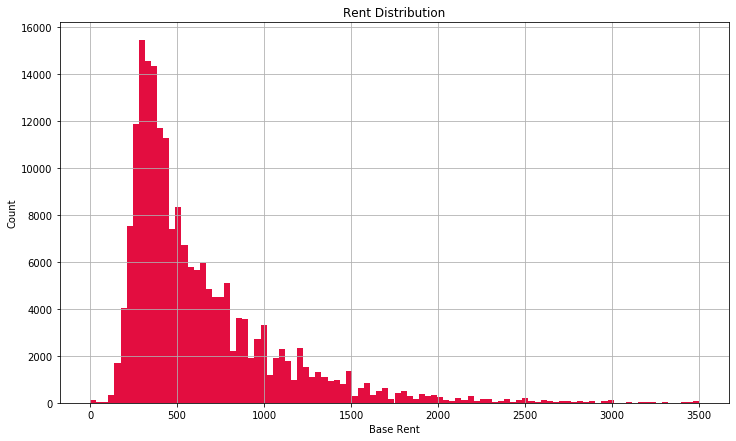

In [99]:
df['baseRent'].hist(bins=100, range=(0,3500), grid=True, color='#e30d40')
plt.title('Rent Distribution')
plt.xlabel('Base Rent')
plt.ylabel('Count')

### Regions
There are big differences in the mean rent depending on the various regions. With Hamburg having the highest mean rent (1180.-) and Thüringen having the lowest mean rent (385.-)

In [100]:
df.groupby(['regio1'])['baseRent'].mean()

regio1
Baden_Württemberg         1060.991542
Bayern                    1015.625075
Berlin                    1174.281680
Brandenburg                515.308303
Bremen                     627.292118
Hamburg                   1180.527945
Hessen                     984.672805
Mecklenburg_Vorpommern     418.739094
Niedersachsen              595.781686
Nordrhein_Westfalen        598.853973
Rheinland_Pfalz            678.026042
Saarland                   591.060360
Sachsen                    434.025950
Sachsen_Anhalt             434.395270
Schleswig_Holstein         643.811158
Thüringen                  385.773160
Name: baseRent, dtype: float64

## Goal
In order to ultimately improve customer experience we answered the following questions in this project:
* What does the supply side of the market look like?
* How much does a flat go for currently?
* What can someone, who is interested in renting out his apartment, ask for it in this environment?

## Cleaning the data
Note: All data cleaning operations are saved in a method for each feature for later reuse in different regression model variants.

### Drop low explanatory value Features
*See documentation for further details on decision process*

In [101]:
df = df.drop(columns=['telekomHybridUploadSpeed','electricityBasePrice','electricityKwhPrice','heatingCosts','energyEfficiencyClass','lastRefurbish','interiorQual','petsAllowed','thermalChar','numberOfFloors','noParkSpaces','heatingType','telekomTvOffer','newlyConst','telekomUploadSpeed','scoutId','firingTypes','geo_bln','yearConstructed','totalRent','houseNumber','geo_krs','interiorQual','petsAllowed','streetPlain','baseRentRange','thermalChar','noRoomsRange','livingSpaceRange','regio2','regio3','date','description','facilities','picturecount','pricetrend','condition','floor'])

### Drop records and if needed standardize values

#### baseRent
Drop outliers of base rent based on domain knowledge
#### yearConstructedRange
Drop records with no value for the independent variable yearConstructedRange
#### livingSpace
Drop outliers of living space and standardize
#### ServiceCharge
Impute missing service charge values with mean and standardize


In [102]:
def prepare_baseRent(df_in):
    df_out = remove_outlier_abs(df_in, 'baseRent', 10, 20000)
    print('Preparation steps completed for baseRent: Outlier removal')
    return df_out
df = prepare_baseRent(df)

def prepare_yearConstructedRange(df_in):
    df_out = df_in.dropna(how='any', subset = ['yearConstructedRange'], axis='rows')
    print('Preparation steps completed for yearConstructedRange: Drop missing values')
    return df_out
df = prepare_yearConstructedRange(df)

def prepare_livingSpace(df_in):
    df_out = remove_outlier_abs(df_in, 'livingSpace', 10, 600)
    df_out.loc[:,'livingSpace'] = scaler.fit_transform(df_out.livingSpace.values.reshape(-1,1))
    print('Preparation steps completed for livingSpace: Outlier removal, standardization')
    return df_out
df = prepare_livingSpace(df)

def prepare_serviceCharge(df_in):
    df_out = df_in
    imp = SimpleImputer(strategy="mean")
    df_out["serviceCharge"] = imp.fit_transform(df_in[["serviceCharge"]]).ravel()
    df_out.loc[:,'serviceCharge'] = scaler.fit_transform(df_out.serviceCharge.values.reshape(-1,1))
    print('Preparation steps completed for serviceCharge: Imputation of missing values, standardization')
    return df_out
df = prepare_serviceCharge(df)

Outliers removed in baseRent : 96
Preparation steps completed for baseRent: Outlier removal
Preparation steps completed for yearConstructedRange: Drop missing values
Outliers removed in livingSpace : 73
Preparation steps completed for livingSpace: Outlier removal, standardization
Preparation steps completed for serviceCharge: Imputation of missing values, standardization


C:\Users\ManuelGrutsch\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### ROOMNUMBERS @@@

3.0      55403
2.0      51234
4.0      16347
1.0      14732
2.5       5370
3.5       5270
5.0       3255
1.5       1743
4.5       1201
6.0        735
5.5        217
7.0        177
8.0         77
6.5         33
9.0         21
7.5         14
10.0        11
11.0         8
12.0         3
15.0         2
8.5          2
160.0        1
221.0        1
100.0        1
230.0        1
45.0         1
140.0        1
23.0         1
32.0         1
21.0         1
Name: noRooms, dtype: int64
Lower Boundary: 0.5
Upper Boundary: 4.5
Outliers would be removed in noRooms : 5765
Preparation steps completed for noRooms: Outlier removal, standardization


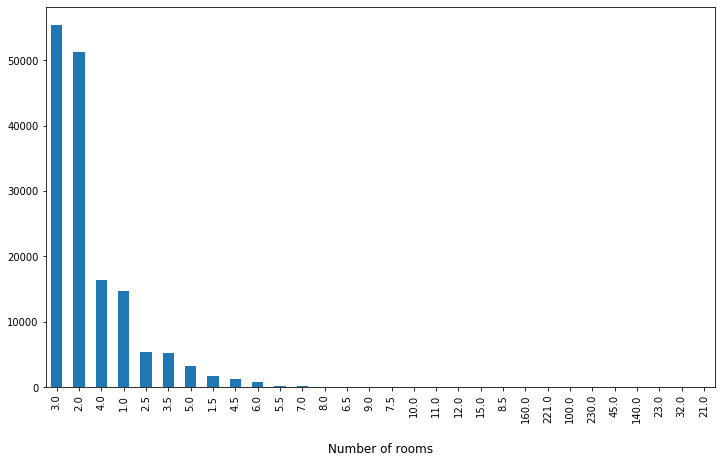

In [103]:
def prepare_noRooms(df_in):
    idx_room_nb_correct = (df_in['noRooms'] % 0.5) == 0
    df_out = df_in[idx_room_nb_correct]
    dist_nbRoom = df_out.noRooms.value_counts()
    print(dist_nbRoom)
    dist_nbRoom.plot.bar()
    plt.xlabel('Number of rooms', fontsize =12, labelpad = 20)
    analyse_outlier_iqr(df_out, 'noRooms')
    idx_room_nb_to_keep = (df_out.noRooms < 20)
    df_out = df_out[idx_room_nb_to_keep]
    df_out.loc[:,'noRooms'] = scaler.fit_transform(df_out.noRooms.values.reshape(-1,1))
    print('Preparation steps completed for noRooms: Outlier removal, standardization')
    return df_out
df = prepare_noRooms(df)

#### GEO PLZ @@@

*NOTE: THIS STEP MAY TAKE A FEW MINUTES.*

In [104]:
idx_kat_isna = (zip_df.Kategorie.isna())
zip_df.Kategorie[idx_kat_isna] = 0
zipCode = zip_df.dropna()
zipCode['Plz'] = zipCode['Plz'].astype(int)
major_city = df.geo_plz.iloc[:]
row_nb = 0;
for nb in major_city:
    row_plz = 0;
    for plz in zipCode.Plz:
        if nb == plz:
            major_city.iloc[row_nb] = zip_df.Kategorie.iloc[row_plz]
            break
        else:
            row_plz = row_plz+1
    row_nb = row_nb + 1

idx_missing = (major_city == "ki") # | (major_city > 1) commented out because troubles with string
major_city[idx_missing] = 0
idx_missing = (major_city > 1)
major_city[idx_missing] = 0
dist_plz = major_city.value_counts()
print(dist_plz)

def add_major_city(df_in):
    df_out = df_in
    df_out['major_city'] = major_city.iloc[:]
    df_out = df_out.drop(columns="geo_plz")
    return df_out
df = add_major_city(df)




C:\Users\ManuelGrutsch\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\ManuelGrutsch\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0    89255
1    66600
Name: geo_plz, dtype: int64


### Dummy Variables @@@

In [105]:
d_regio1 = pd.get_dummies(data=df['regio1'], drop_first=True)
d_typeOfFlat = pd.get_dummies(data=df['typeOfFlat'], drop_first=True)
d_yearConstructedRange = pd.get_dummies(data=df['yearConstructedRange'], drop_first=True)
df_regr = df.drop(columns=['regio1', 'typeOfFlat', 'yearConstructedRange','baseRent'])
df_regr = df_regr.join(d_regio1)
df_regr = df_regr.join(d_typeOfFlat)
df_regr = df_regr.join(d_yearConstructedRange)




## Regression

### Baseline Model

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     6206.
Date:                Mon, 27 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:18:40   Log-Likelihood:            -6.5444e+05
No. Observations:               93513   AIC:                         1.309e+06
Df Residuals:                   93471   BIC:                         1.309e+06
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        694.3075      4.740    146.491      0.0

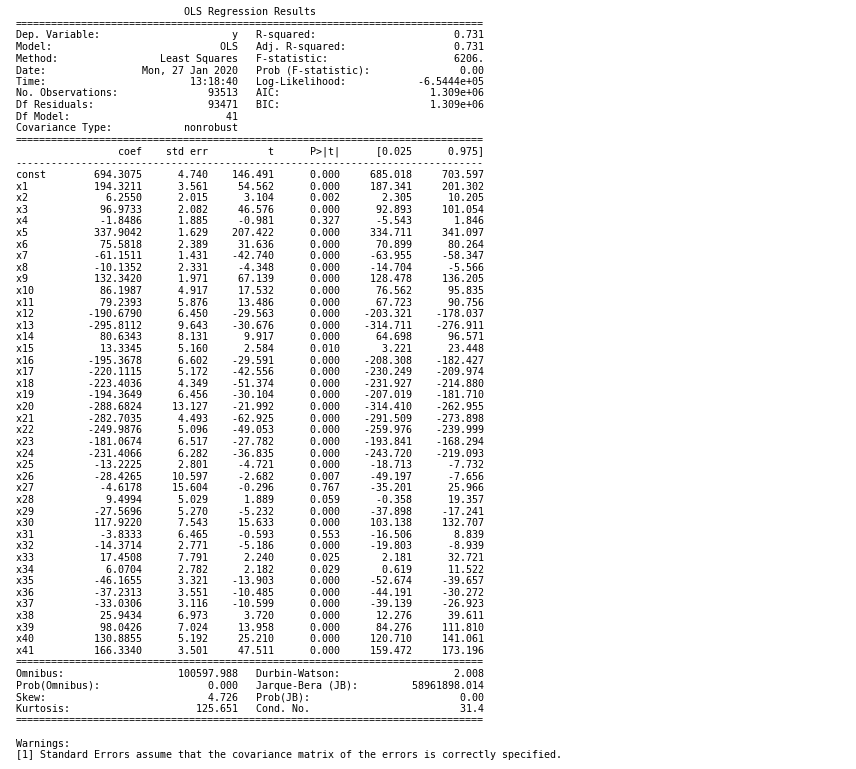

In [106]:
x = df_regr
y = df['baseRent']

cleaned_df = df_regr.join(df['baseRent'])

x_train, x_testval, y_train, y_testval = train_test_split(x, y, test_size= 0.4)
x_test, x_val, y_test, y_val = train_test_split(x_testval, y_testval, test_size= 0.5)

x_train = np.array(x_train,dtype='float64')
y_train = np.array(y_train,dtype='float64')
x_train = sm.add_constant(x_train) #adding constant

# compute the correlations of the different independent variables

corr = df_regr.corr()
corr.style.background_gradient(cmap='coolwarm')

#plot correlation between features using Pearson Correlation
import seaborn as sns
"""plt.figure(figsize=(100,80))
cor = cleaned_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()"""

model = sm.OLS(y_train,x_train) # apply the statistical model for it
result = model.fit()
print(result.summary())

#get parameters as an array
result.params

#saving output as png file
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(result.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.savefig('output.png')


regressor = LinearRegression() # apply the normal linear regression
regressor.fit(x_train, y_train)
print(regressor.intercept_)
print(regressor.coef_)
print(regressor.score(x_train,y_train))


### Feature Selection
If we look at the correlation pearson correlation heatmap we can identify the features with a high correlation to dependent variable. These features should be included in the regression.

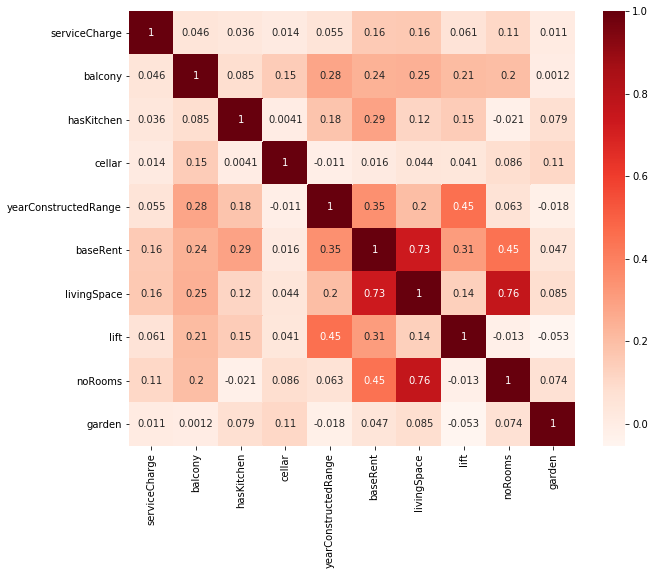

In [107]:
plt.figure(figsize=(10,8))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

We can see that livingSpace (0.75) followed by serviceCharge (0.7) and noRooms(0.46) have a high correlation to the dependent variable baseRent.
We first compute a model with the highest independent variable. This will give us a good orientation to how well a simple model will perform.
As we have discussed adding complexity only makes sense if there is a significant increase in performance. 
From there on we will add features and see if the performance gets better. One thing to consider is that the heatmap only makes sense for numerical
variables not categorical. So it might be that the categorical variables add significant performance.

We have to first consider that we dropped a lot of records in the earlier steps. We want to make sure that we repeat the entire process
each time so we consider the entire available data in our model.


### Model 2
Independent Variables:
* livingSpace
* serviceCharge

#### Preparation

In [108]:
df2 = rawdata
df2 = df2[['baseRent','livingSpace']]

df2 = prepare_baseRent(df2)
df2 = prepare_livingSpace(df2)

Outliers removed in baseRent : 96
Preparation steps completed for baseRent: Outlier removal
Outliers removed in livingSpace : 127
Preparation steps completed for livingSpace: Outlier removal, standardization


C:\Users\ManuelGrutsch\Anaconda3\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


#### Regression

In [109]:
x2 = df2['livingSpace']
y2 = df2['baseRent']

x_train, x_testval, y_train, y_testval = train_test_split(x2, y2, test_size= 0.4)
x_test, x_val, y_test, y_val = train_test_split(x_testval, y_testval, test_size= 0.5)

x_train = np.array(x_train,dtype='float64')
y_train = np.array(y_train,dtype='float64')

x_train = sm.add_constant(x_train) #adding constant

model = sm.OLS(y_train,x_train) # apply the statistical model for it
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                 1.260e+05
Date:                Mon, 27 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:18:47   Log-Likelihood:            -8.6572e+05
No. Observations:              118893   AIC:                         1.731e+06
Df Residuals:                  118891   BIC:                         1.731e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        640.2422      1.020    627.816      0.0

### Model 3
Independent variables:
* livingSpace
* serviceCharge

#### Preparation

In [110]:
df3 = rawdata
df3 = df3[['baseRent','livingSpace', 'serviceCharge']]

df3 = prepare_baseRent(df3)
df3 = prepare_serviceCharge(df3)
df3 = prepare_livingSpace(df3)


Outliers removed in baseRent : 96
Preparation steps completed for baseRent: Outlier removal
Preparation steps completed for serviceCharge: Imputation of missing values, standardization
Outliers removed in livingSpace : 127
Preparation steps completed for livingSpace: Outlier removal, standardization


C:\Users\ManuelGrutsch\Anaconda3\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


#### Regression

In [111]:
x3 = df3[['livingSpace','serviceCharge']]
y3 = df3['baseRent']


x_train, x_testval, y_train, y_testval = train_test_split(x3, y3, test_size= 0.4)
x_test, x_val, y_test, y_val = train_test_split(x_testval, y_testval, test_size= 0.5)

x_train = np.array(x_train,dtype='float64')
y_train = np.array(y_train,dtype='float64')

x_train = sm.add_constant(x_train)

model = sm.OLS(y_train,x_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                 7.404e+04
Date:                Mon, 27 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:18:51   Log-Likelihood:            -8.5977e+05
No. Observations:              118893   AIC:                         1.720e+06
Df Residuals:                  118890   BIC:                         1.720e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        642.1451      0.970    661.986      0.0

### Model 4
Independent variables:
* livingSpace
* serviceCharge
* noRooms

#### Preparation

Outliers removed in baseRent : 96
Preparation steps completed for baseRent: Outlier removal
Outliers removed in livingSpace : 127
Preparation steps completed for livingSpace: Outlier removal, standardization
Preparation steps completed for serviceCharge: Imputation of missing values, standardization
3.0      68548
2.0      65901
4.0      20537
1.0      19656
2.5       6962
3.5       6477
5.0       4265
1.5       2448
4.5       1513
6.0       1001
7.0        255
5.5        250
8.0        103
6.5         45
9.0         31
10.0        19
7.5         16
11.0         9
12.0         4
15.0         4
8.5          2
32.0         1
18.0         1
25.0         1
23.0         1
560.0        1
140.0        1
200.0        1
45.0         1
160.0        1
305.0        1
221.0        1
100.0        1
230.0        1
22.0         1
21.0         1
16.0         1
Name: noRooms, dtype: int64


C:\Users\ManuelGrutsch\Anaconda3\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Lower Boundary: 0.5
Upper Boundary: 4.5
Outliers would be removed in noRooms : 7533
Preparation steps completed for noRooms: Outlier removal, standardization


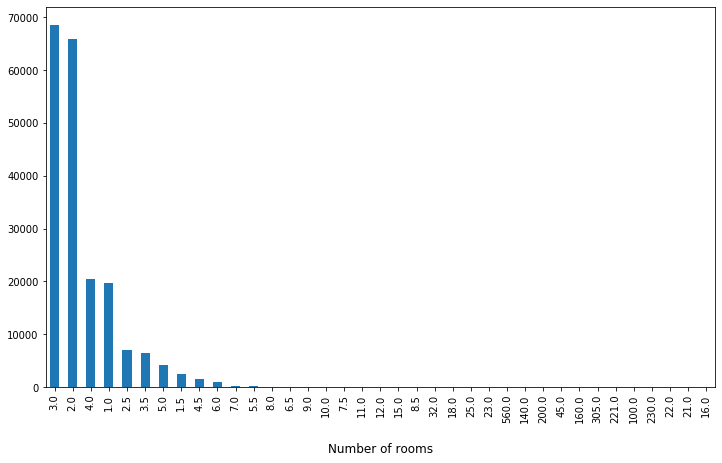

In [112]:
df4 = rawdata
df4 = df4[['baseRent','livingSpace', 'serviceCharge', 'noRooms']]

df4 = prepare_baseRent(df4)
df4 = prepare_livingSpace(df4)
df4 = prepare_serviceCharge(df4)
df4 = prepare_noRooms(df4)

#### Regression

In [113]:
x4 = df4[['livingSpace','serviceCharge', 'noRooms']]
y4 = df4['baseRent']


x_train, x_testval, y_train, y_testval = train_test_split(x4, y4, test_size= 0.4)
x_test, x_val, y_test, y_val = train_test_split(x_testval, y_testval, test_size= 0.5)

x_train = np.array(x_train,dtype='float64')
y_train = np.array(y_train,dtype='float64')

x_train = sm.add_constant(x_train)

model = sm.OLS(y_train,x_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                 5.312e+04
Date:                Mon, 27 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:18:55   Log-Likelihood:            -8.5586e+05
No. Observations:              118828   AIC:                         1.712e+06
Df Residuals:                  118824   BIC:                         1.712e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        641.3643      0.943    680.358      0.0

### Model 5
Independent variables:
* livingSpace
* serviceCharge
* noRooms
* regio1

#### Preparation

Outliers removed in baseRent : 96
Preparation steps completed for baseRent: Outlier removal
Outliers removed in livingSpace : 127
Preparation steps completed for livingSpace: Outlier removal, standardization


C:\Users\ManuelGrutsch\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Preparation steps completed for serviceCharge: Imputation of missing values, standardization
3.0      68548
2.0      65901
4.0      20537
1.0      19656
2.5       6962
3.5       6477
5.0       4265
1.5       2448
4.5       1513
6.0       1001
7.0        255
5.5        250
8.0        103
6.5         45
9.0         31
10.0        19
7.5         16
11.0         9
12.0         4
15.0         4
8.5          2
32.0         1
18.0         1
25.0         1
23.0         1
560.0        1
140.0        1
200.0        1
45.0         1
160.0        1
305.0        1
221.0        1
100.0        1
230.0        1
22.0         1
21.0         1
16.0         1
Name: noRooms, dtype: int64
Lower Boundary: 0.5
Upper Boundary: 4.5
Outliers would be removed in noRooms : 7533
Preparation steps completed for noRooms: Outlier removal, standardization


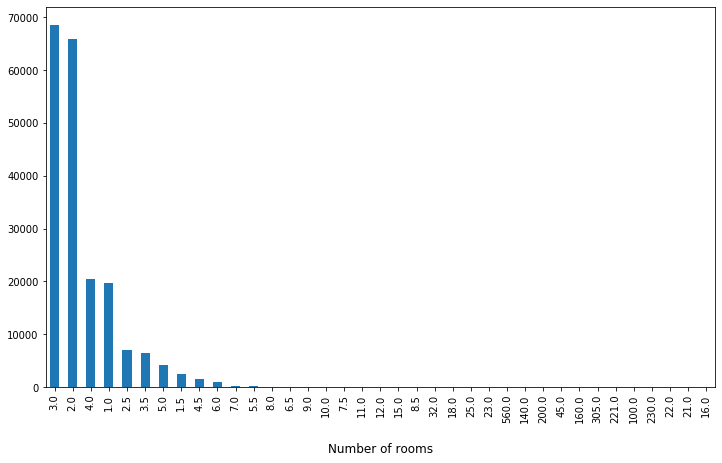

In [114]:
df5 = rawdata
df5 = df5[['baseRent','livingSpace', 'serviceCharge', 'noRooms', 'regio1']]

d5_regio1 = pd.get_dummies(data=df5['regio1'], drop_first=True)
df5 = df5.drop(columns=['regio1'])
df5 = df5.join(d5_regio1)

df5 = prepare_baseRent(df5)
df5 = prepare_livingSpace(df5)
df5 = prepare_serviceCharge(df5)
df5 = prepare_noRooms(df5)

#### Regression

In [115]:
x5 = df5.drop(columns=['baseRent'])
y5 = df5['baseRent']


x_train, x_testval, y_train, y_testval = train_test_split(x5, y5, test_size= 0.4)
x_test, x_val, y_test, y_val = train_test_split(x_testval, y_testval, test_size= 0.5)

x_train = np.array(x_train,dtype='float64')
y_train = np.array(y_train,dtype='float64')

x_train = sm.add_constant(x_train)

model = sm.OLS(y_train,x_train)
result = model.fit()
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                 1.335e+04
Date:                Mon, 27 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:19:02   Log-Likelihood:            -8.4413e+05
No. Observations:              118828   AIC:                         1.688e+06
Df Residuals:                  118809   BIC:                         1.688e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        836.7188      3.593    232.874      0.0